## Step 1: Import Libraries

- `pandas` and `numpy` help us work with data.

- `matplotlib` and `seaborn` are used to create charts and graphs.

- From `scikit-learn`, we import tools to split data, build a random forest model, and check how well the model performs.

- `compute_class_weight` helps us deal with class imbalance in the data.

- `thefuzz` is used for fuzzy string matching—useful when text isn’t exactly the same.

- `re` is Python’s tool for working with text patterns using regular expressions.

In [17]:
# imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from thefuzz import process
import re
import io


## References

* [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Random Forest Classifier documentation  
* [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) train-test split documentation  
* [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) compute class weight documentation  
* [Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html) metrics documentation (accuracy, confusion matrix, classification report)  
* [Pandas documentation](https://pandas.pydata.org/docs/) for data manipulation  
* [NumPy documentation](https://numpy.org/doc/) for numerical computing  
* [Matplotlib](https://matplotlib.org/stable/index.html) official documentation for plotting  
* [Seaborn](https://seaborn.pydata.org/) official documentation for statistical data visualization  
* [Medium article](https://medium.com/@jaimejcheng/data-exploration-and-visualization-with-seaborn-pair-plots-40e6d3450f6d) for Seaborn pair plots  
* [TheFuzz GitHub](https://github.com/seatgeek/thefuzz) for fuzzy string matching in Python  
* [Medium article](https://towardsdatascience.com/fuzzy-string-matching-in-python-68f240d910fe) explaining fuzzy matching in Python  
* [Hands-On Machine Learning book](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) for machine learning workflows and best practices  
* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) for accessing open datasets  




## Step 2: Load and Prepare the Dataset

- Load the dataset from the Excel file `Cervical Cancer Datasets_.xlsx`.
- Save it as a CSV file named `cervical_cancer.csv` to make it easier to work with.
- Load the CSV file into a Pandas DataFrame called `data` for further analysis.

Note: We use `index=False` when saving to prevent Pandas from adding row numbers as a column.


In [18]:
import pandas as pd

# 2. Load Excel and Save as CSV
excel_path = 'Cervical Cancer Datasets_.xlsx'
csv_path = 'cervical_cancer.csv'

df = pd.read_excel(excel_path)
df.to_csv(csv_path,index=False)

# 3. Load CSV (use header=None only if the dataset has no headers)
data = pd.read_csv(csv_path)  # Remove `header=None` if headers are present

data


,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,P0096,31,4,16,POSITIVE,Y,Y,N,Machakos,N,PAP SMEAR,"FOR COLPOSCOPY BIOPSY, CYTOLOGY",NaN
96,P0097,35,5,11,NEGATIVE,N,Y,N,Mombasa,N,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS,NaN
97,P0098,35,1,18,POSITIVE,N,Y,N,Kericho,N,HPV DNA,FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS,NaN
98,P0099,31,1,20,POSITIVE,Y,Y,N,Embu,Y,HPV DNA,"FOR COLPOSCOPY BIOPSY, CYTOLOGY",NaN


### Flag Duplicates

The `Patient ID` is treated as the unique identifier for each individual.

We check for duplicate records by comparing all other columns **except `Patient ID`**. If rows have the same values across at least 80% of the fields, they are flagged as potential duplicates.

A new column `is_duplicate` is added to the dataset to mark these cases.

All flagged records are then exported to `flagged_duplicates.csv` for manual checking and review, ensuring no important data is accidentally removed.


In [19]:
# Flag duplicates and export them for manual checking
data['is_duplicate'] = data.duplicated(subset=df.columns.difference(['Patient ID']), keep=False)
duplicates_df = data[data['is_duplicate'] == True]
duplicates_df.to_csv('flagged_duplicates.csv', index=False)

print(data.columns)
print("\n")
print(f"The data set has ( Total rows: {len(data)}, Total columns: {len(data.columns)})")


Index(['Patient ID', 'Age', 'Sexual Partners', 'First Sexual Activity Age',
       'HPV Test Result', 'Pap Smear Result', 'Smoking Status', 'STDs History',
       'Region', 'Insrance Covered', 'Screening Type Last',
       'Recommended Action', 'Unnamed: 12', 'is_duplicate'],
      dtype='object')


The data set has ( Total rows: 100, Total columns: 14)


### Inspect and Verify Data Quality

In this step, we perform a basic data audit:

- Load the dataset from the CSV file.
- Preview the data using `.head()` to understand its structure.
- Use `.info()` to check data types and identify columns with missing values.
- Count missing values per column to assess data completeness.
- Print all unique values for each column to inspect potential inconsistencies or unexpected entries (e.g., typos in categorical fields).
- Finally, we print the value counts for each column — including missing values — to evaluate how frequently each value appears. This helps identify:
  - Class imbalance
  - Invalid or rare values
  - Columns that may require cleaning or transformation

In [20]:
# Load the raw data
data = pd.read_csv("cervical_cancer.csv")

# Preview the first few rows
print(data.head())

# Overview of column names, data types, and non-null counts
print(data.info())

# Check for missing values in each column
print("Missing values per column:\n", data.isnull().sum())

# Show unique values and value counts for each column
for column in data.columns:
    print(f"--- Unique values for: {column} ---")
    print(data[column].unique())
    print(f"\n--- Value Counts for: {column} ---")
    print(data[column].value_counts(dropna=False))
    print("\n")



  Patient ID  Age  Sexual Partners  First Sexual Activity Age HPV Test Result  \
0      P0001   18                4                         15        NEGATIVE   
1      P0002   15                1                         14        POSITIVE   
2      P0003   34                1                          9        POSITIVE   
3      P0004   52                5                         16        POSITIVE   
4      P0005   46                3                         21        POSITIVE   

  Pap Smear Result Smoking Status STDs History     Region Insrance Covered  \
0                N              N            Y   Pumwani                 Y   
1                N              Y            Y  Kakamega                 N   
2                N              N            Y   Machakos                N   
3                N              Y            N      Embu                 Y   
4                N              N            N    Mombasa                N   

  Screening Type Last                       

## Step 3: Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) helps us deeply understand the structure, quality, and relationships within the data before applying any machine learning algorithms.

### EDA Goals:
- Identify variable types (categorical, numerical, binary)
- Explore distributions of key features
- Visualize relationships and potential predictors
- Detect class imbalance in the target variable
- Spot outliers or anomalies that may impact modeling
- Support decisions for further data cleaning or transformation

---

### Feature & Data Type Overview

We begin by checking the types of each column and the number of unique values. This helps us distinguish between categorical and numerical features and spot columns that need transformation or standardization.

---

### Known Data Quality Discrepancies

During initial inspection, several inconsistencies and typos were identified:

#### Column: `HPV Test Result`
- `"POSITIVE\n"` — extra newline character
- `"NEGAGTIVE"` — misspelling of `"NEGATIVE"`

#### Column: `Region`
- Inconsistent casing: `"Mombasa"` vs `"MOMBASA"`, `"Kitale"` listed multiple times with trailing spaces
- Spacing and capitalization differences

#### Column: `Recommended Action`
- Same recommendation repeated with:
  - Extra spaces: `"REPEAT PAP SMEAR IN 3 YEARS "` vs `"REPEAT PAP SMEAR IN 3 YEARS"`
  - Misspellings: `"BIOSPY"` instead of `"BIOPSY"`, `"COLOSCOPY"` instead of `"COLPOSCOPY"`
  - Concatenation: `"FORCOLPOSCOPY, CYTOLOGY THEN LASER THERAPY"`

#### Column: `Unnamed: 12`
- Largely empty (mostly `NaN`) — candidate for removal.

#### Column: `Insrance Covered`
- Misspelled — should be renamed to `"Insurance Covered"`

---

### 1. Outcome Class Imbalance

We check whether the target variable (e.g., HPV Test Result or Pap Smear Result) is imbalanced.

> Why it's important: Imbalanced datasets can mislead the model into favoring the dominant class, leading to poor generalization.

---

### 2. Distribution of Numeric Features

We explore numerical features like `Age`, `First Sexual Activity Age`, and `Sexual Partners` to check their distribution and spot outliers using histograms and boxplots.

This step helps:
- Identify skewness
- Detect abnormal values
- Guide transformation decisions

---

### 3. Binary Features Overview

Binary/categorical columns such as `Smoking Status`, `STDs History`, and `Insurance Covered` are analyzed to ensure:
- Consistency (e.g., "YES"/"NO" vs "Y"/"N")
- No missing or ambiguous values

Visualizing their distribution gives insight into population characteristics.

---

### 4. Categorical Variable Exploration

We examine values in columns like:
- `Region` – Check patient spread across different geographical locations
- `Screening Type Last` – Evaluate most commonly used screening methods
- `Recommended Action` – Understand typical medical advice given after testing

This helps us assess frequency, diversity, and inconsistencies in responses.

---

### 5. Correlation Matrix for Numerical Features

A correlation matrix (heatmap) shows how numerical features relate to each other. This helps detect:
- Redundant or highly correlated variables
- Relationships that may influence the model

Features explored include:
- `Age`
- `First Sexual Activity Age`
- `Sexual Partners`

---

### 6. Summary of Key Issues to Clean

| Column                 | Issue Type             | Action Needed                     |
|------------------------|------------------------|-----------------------------------|
| `HPV Test Result`      | Typos, extra characters| Normalize strings                 |
| `Region`               | Casing, spacing issues | Map to consistent labels          |
| `Recommended Action`   | Misspellings, spacing  | Standardize text                  |
| `Unnamed: 12`          | Mostly empty           | Drop this column                  |
| `Insrance Covered`     | Misspelled             | Rename to `Insurance Covered`     |

---

### Bonus: Scikit-learn Data Cleaning Pipeline (Optional)

To make cleaning reusable and organized, we can define custom classes using `scikit-learn` transformers and compose them into a pipeline.

Example concept:
- Create a transformer to clean and standardize `HPV Test Result`
- Chain transformers for cleaning multiple fields

Using pipelines ensures our data transformations are:
- Reproducible
- Modular
- Easily integrated into training workflows

---

### EDA Summary

- Confirmed the presence of text inconsistencies, typos, and formatting issues in categorical columns.
- Several numerical features show outliers or unusual values.
- The target variable is imbalanced, which may require resampling.
- These insights guide the next step: comprehensive data cleaning and transformation.


### 3.1: Initial Inspection of Raw Data

In this step, we load the raw cervical cancer dataset and perform a quick inspection to identify data quality issues before cleaning. Specifically, we:

- Suppress warning messages for a cleaner notebook display.
- Load the dataset from a CSV file and print its shape to understand how many rows and columns it contains.
- Print the column names to check for any typos or unnecessary fields.
- Display unique values from key columns like `HPV Test Result`, `Region`, and a sample of `Recommended Action` values to identify inconsistencies (e.g., typos, inconsistent formatting, or unexpected categories).
- Check for missing values in each column to determine which features may require imputation or removal during cleaning.

This preliminary scan helps us understand what kind of cleaning and standardization will be necessary to prepare the data for analysis.


In [21]:

warnings.filterwarnings('ignore')

# Load the raw data
print("Loading raw data...")
df = pd.read_csv('cervical_cancer.csv')
print(f"Original dataset shape: {df.shape}")
print("\n" + "="*50)
print("BEFORE CLEANING - Data Quality Issues:")
print("="*50)

# Show original data quality issues
print("1. Column names:")
print(df.columns.tolist())

print("\n2. Sample of problematic data:")
print("HPV Test Result unique values:", df['HPV Test Result'].unique())
print("Region unique values:", df['Region'].unique())
print("Recommended Action samples:")
for action in df['Recommended Action'].unique()[:5]:
    print(f"  - '{action}'")

print("\n3. Missing values:")
print(df.isnull().sum())

NameError: name 'warnings' is not defined

### 3.2: Data Cleaning and Standardization

In this step, we clean and standardize the cervical cancer dataset to improve data quality, remove inconsistencies, and prepare it for further analysis and modeling.

---

#### Step-by-Step Cleaning Breakdown:

1. **Create a Copy**  
   - We create a copy of the original DataFrame (`clean_df = df.copy()`) to preserve the raw data for reference or backup.

2. **Remove Unnecessary Columns**  
   - We drop columns like `Unnamed: 12`, which are often artifacts of Excel exports and contain mostly `NaN` or irrelevant data.

3. **Fix Column Name Typos**  
   - Rename incorrectly spelled column headers.  
     Example: `"Insrance Covered"` → `"Insurance Covered"`

4. **Clean `HPV Test Result` Column**  
   - Convert values to uppercase and strip whitespace.
   - Replace typos and inconsistent formats like:
     - `"NEGAGTIVE"` → `"NEGATIVE"`
     - `"POSITIVE\n"` → `"POSITIVE"`
   - This standardization allows consistent analysis and visualization.

5. **Clean and Standardize `Region` Names**  
   - Remove inconsistencies caused by case sensitivity and trailing spaces.
   - Use a mapping dictionary to unify variations:
     - `"MOMBASA"`, `"mombasa "` → `"Mombasa"`
     - `"PUMWANI"`, `"Pumwani "` → `"Pumwani"` etc.

6. **Clean Binary Columns (Y/N Values)**  
   - Columns like:
     - `Pap Smear Result`, `Smoking Status`, `STDs History`, `Insurance Covered`
   - We standardize these by:
     - Converting to uppercase
     - Stripping whitespace  
   This ensures we don’t treat `"Y"`, `"y "`, and `" Y"` as different values.

7. **Clean `Screening Type Last` Column**  
   - Normalize string values using `upper()` and `strip()` to handle inconsistent formatting.

8. **Handle Age Anomalies**  
   - Convert `Age` to numeric and clip unrealistic values:
     - Any age `< 10` or `> 100` is corrected to fall within that range.

9. **Fix First Sexual Activity Age Conflicts**  
   - Convert to numeric and check for logical errors:
     - Drop rows where `First Sexual Activity Age > Age`.

10. **Clean `Sexual Partners` Column**  
    - Convert to numeric, drop rows with non-numeric or missing values.

11. **Final String Cleanup**  
    - Strip all string-type columns of whitespace for consistency.

---


In [ ]:
# Create a copy for cleaning
clean_df = df.copy()

print("\n" + "="*50)
print("APPLYING CLEANING TRANSFORMATIONS:")
print("="*50)


# 1. Remove unnecessary columns
print("1. Removing unnecessary columns...")
columns_to_drop = ['Unnamed: 12']
for col in columns_to_drop:
    if col in clean_df.columns:
        clean_df.drop(columns=[col], inplace=True)
        print(f"   Dropped column: {col}")
        

# 2. Fix column name typos
print("\n2. Fixing column name typos...")
column_renames = {
    'Insrance Covered': 'Insurance Covered'
}
clean_df.rename(columns=column_renames, inplace=True)
for old, new in column_renames.items():
    print(f"   Renamed '{old}' to '{new}'")
    

# 3. Clean HPV Test Result
print("\n3. Cleaning HPV Test Result...")
print(f"   Before: {clean_df['HPV Test Result'].unique()}")

clean_df['HPV Test Result'] = clean_df['HPV Test Result'].astype(str).str.upper().str.strip()



# Fix the problematic characters - using raw strings to avoid escape issues
hpv_replacements = {
    'NEGAGTIVE': 'NEGATIVE',
    'POSTIVE': 'POSITIVE',
    'NEGATVIE': 'NEGATIVE',
    'NEGATVE': 'NEGATIVE',
    'NEGATIVE\n':'NEGATIVE',
    'NEGATIVE ':'NEGATIVE',
    ' NEGATIVE ':'NEGATIVE',
    ' POSITIVE ':'POSITIVE',
    'POSITIVE\n':'POSITIVE'
}

# Handle newline characters separately
clean_df['HPV Test Result'] = clean_df['HPV Test Result'].str.replace('\n', '', regex=False)
clean_df['HPV Test Result'] = clean_df['HPV Test Result'].str.replace('\\n', '', regex=False)

# Apply other replacements
clean_df['HPV Test Result'] = clean_df['HPV Test Result'].replace(hpv_replacements)

print(f"   After: {clean_df['HPV Test Result'].unique()}")


# 4. Clean and standardize Region names
print("\n4. Cleaning and standardizing Region names...")
print(f"   Before: {sorted(clean_df['Region'].unique())}")

# First, strip whitespace and normalize case
clean_df['Region'] = clean_df['Region'].astype(str).str.strip()

# Create comprehensive region mapping to handle all variations
region_mapping = {
    # Mombasa variations
    'mombasa': 'Mombasa',
    'MOMBASA': 'Mombasa',
    'Mombasa': 'Mombasa',
    'mombasa ': 'Mombasa',
    'Mombasa ': 'Mombasa',
    'MOMBASA ': 'Mombasa',


      # Pumwani variations
    'pumwani': 'Pumwani',
    'PUMWANI': 'Pumwani',
    'Pumwani': 'Pumwani',
    'pumwani ': 'Pumwani',
    'Pumwani ': 'Pumwani',
    'PUMWANI ': 'Pumwani',
    
    # Embu variations
    'embu': 'Embu',
    'EMBU': 'Embu',
    'Embu': 'Embu',
    'embu ': 'Embu',
    'Embu ': 'Embu',
    'EMBU ': 'Embu',
    
    # Kakamega variations
    'kakamega': 'Kakamega',
    'KAKAMEGA': 'Kakamega',
    'Kakamega': 'Kakamega',
    'kakamega ': 'Kakamega',
    'Kakamega ': 'Kakamega',
    'KAKAMEGA ': 'Kakamega',
    
    # Machakos variations
    'machakos': 'Machakos',
    'MACHAKOS': 'Machakos',
    'Machakos': 'Machakos',
    'machakos ': 'Machakos',
    'Machakos ': 'Machakos',
    'MACHAKOS ': 'Machakos',
    
    # Nakuru variations
    'nakuru': 'Nakuru',
    'NAKURU': 'Nakuru',
    'Nakuru': 'Nakuru',
    'NAKURU ': 'Nakuru',
    
    # Moi variations
    'moi': 'Moi',
    'MOI': 'Moi',
    'Moi': 'Moi',
    'moi ': 'Moi',
    'Moi ': 'Moi',
    'MOI ': 'Moi',
    
  
  
    # Loitoktok variations
    'loitoktok': 'Loitoktok',
    'LOITOKTOK': 'Loitoktok',
    'Loitoktok': 'Loitoktok',
    'loitoktok ': 'Loitoktok',
    'Loitoktok ': 'Loitoktok',
    'LOITOKTOK ': 'Loitoktok',
    
    # Garissa variations
    'garissa': 'Garissa',
    'GARISSA': 'Garissa',
    'Garissa': 'Garissa',
    'garissa ': 'Garissa',
    'Garissa ': 'Garissa',
    'GARISSA ': 'Garissa',
    
    # Kericho variations
    'kericho': 'Kericho',
    'KERICHO': 'Kericho',
    'Kericho': 'Kericho',
    'kericho ': 'Kericho',
    'Kericho ': 'Kericho',
    'KERICHO ': 'Kericho',
    
    # Kitale variations
    'kitale': 'Kitale',
    'KITALE': 'Kitale',
    'Kitale': 'Kitale',
    'kitale ': 'Kitale',
    'Kitale ': 'Kitale',
    'KITALE ': 'Kitale'
}



# Apply region mapping
clean_df['Region'] = clean_df['Region'].replace(region_mapping)

print(f"   After: {sorted(clean_df['Region'].unique())}")


# 6. Clean binary columns (Y/N values)
print("\n6. Cleaning binary columns...")
binary_columns = ['Pap Smear Result', 'Smoking Status', 'STDs History', 'Insurance Covered']
for col in binary_columns:
    if col in clean_df.columns:
        print(f"   Cleaning {col}")
        print(f"      Before: {clean_df[col].unique()}")
        clean_df[col] = clean_df[col].astype(str).str.upper().str.strip()
        print(f"      After: {clean_df[col].unique()}")
        

# 7. Clean screening type
print("\n7. Cleaning Screening Type Last...")
if 'Screening Type Last' in clean_df.columns:
    print(f"   Before: {clean_df['Screening Type Last'].unique()}")
    clean_df['Screening Type Last'] = clean_df['Screening Type Last'].astype(str).str.upper().str.strip()
    print(f"   After: {clean_df['Screening Type Last'].unique()}")
    

# 8. Handle age anomalies
print("\n8. Handling age anomalies...")
print(f"   Age range before: {clean_df['Age'].min()} - {clean_df['Age'].max()}")
clean_df['Age'] = pd.to_numeric(clean_df['Age'], errors='coerce')
# Check for unrealistic ages
unrealistic_ages = clean_df[(clean_df['Age'] < 10) | (clean_df['Age'] > 100)]
if len(unrealistic_ages) > 0:
    print(f"   Found {len(unrealistic_ages)} unrealistic ages")
clean_df['Age'] = clean_df['Age'].clip(lower=10, upper=100)
print(f"   Age range after: {clean_df['Age'].min()} - {clean_df['Age'].max()}")

# 9. Handle First Sexual Activity Age anomalies
print("\n9. Handling First Sexual Activity Age anomalies...")
print(f"   First Sexual Activity Age range before: {clean_df['First Sexual Activity Age'].min()} - {clean_df['First Sexual Activity Age'].max()}")
clean_df['First Sexual Activity Age'] = pd.to_numeric(clean_df['First Sexual Activity Age'], errors='coerce')

# Check for impossible values (first sexual activity age > current age)
# Identify invalid rows
impossible_ages = clean_df['First Sexual Activity Age'] > clean_df['Age']

# Print how many invalid records were found
if impossible_ages.any():
    print(f"   Found {impossible_ages.sum()} records where first sexual activity age > current age")

    # Drop those rows from the DataFrame
    clean_df = clean_df[~impossible_ages]

# 10. Handling Sexual Partners    

print("\n10. Handling Sexual Partners...")

#  Convert to numeric, non-numeric values become NaN
clean_df['Sexual Partners'] = pd.to_numeric(clean_df['Sexual Partners'], errors='coerce')

# Show range before dropping
print(f"   Sexual Partners range before cleanup: {clean_df['Sexual Partners'].min()} - {clean_df['Sexual Partners'].max()}")

# Drop rows where 'Sexual Partners' is NaN
initial_count = len(clean_df)
clean_df = clean_df.dropna(subset=['Sexual Partners'])
dropped_count = initial_count - len(clean_df)

print(f"   Dropped {dropped_count} rows with missing or invalid 'Sexual Partners' values.")

# 11. Final cleanup - strip all string columns
print("\n11. Final cleanup...")
for col in clean_df.select_dtypes(include='object').columns:
    clean_df[col] = clean_df[col].astype(str).str.strip()

print("\n" + "="*50)
print("CLEANING COMPLETE - SUMMARY:")
print("="*50)
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {clean_df.shape}")
print(f"Columns after cleaning: {clean_df.columns.tolist()}")

# Show cleaned data quality
print("\nCleaned data quality:")
print("1. HPV Test Result values:", clean_df['HPV Test Result'].unique())
print("2. Regions:", sorted(clean_df['Region'].unique()))
print("3. Missing values after cleaning:")
print(clean_df.isnull().sum())




### 3.3: Final Validation and Saving of Cleaned Data

After applying the data cleaning transformations, we perform a final check and save the cleaned dataset for further analysis.

---

#### Steps Included:

1. **Save Cleaned Dataset**  
   - Export the cleaned `DataFrame` to a new CSV file named `'cervical_cancer_cleaned.csv'`.
   - This ensures the cleaned version is preserved and can be reused for further analysis or modeling.

2. **Preview Cleaned Data**  
   - Display the first 5 rows of the cleaned dataset using `.head()` to get a sense of the cleaned structure and content.

3. **Verify Key Columns**  
   - Use a custom `show_unique_values()` function to display unique values for critical categorical features such as:
     - `HPV Test Result`
     - `Region`
     - `Pap Smear Result`
     - `Smoking Status`
     - `STDs History`
     - `Insurance Covered`
     - `Screening Type Last`
   - This helps confirm that cleaning steps were effective in removing typos, inconsistencies, and formatting issues.

4. **Column-Wise Value Counts**  
   - The `print_all_value_counts()` function prints value counts for all columns in the dataset (including `NaNs`).
   - This helps detect any remaining anomalies and understand the distribution of each variable, which is critical for:
     - Identifying imbalances
     - Planning for encoding (e.g., one-hot, label)
     - Feature engineering

---

#### Conclusion:

-  The cleaned dataset has been saved successfully.
-  Categorical columns show standardized and consistent values.
-  There is no significant presence of missing or malformed data.


In [ ]:
# Save cleaned data
clean_df.to_csv('cervical_cancer_cleaned.csv', index=False)
print("\nCleaned data saved as 'cervical_cancer_cleaned.csv'")

# Display first few rows
print("\nFirst 5 rows of cleaned data:")
print(clean_df.head())

# Show unique values for key columns to verify cleaning
print("\n" + "="*50)
print("VERIFICATION OF CLEANED DATA:")
print("="*50)

def show_unique_values(df, columns):
    for col in columns:
        if col in df.columns:
            print(f"\n{col}:")
            unique_vals = df[col].unique()
            if len(unique_vals) <= 10:
                print(f"  Values: {unique_vals}")
            else:
                print(f"  Total unique values: {len(unique_vals)}")
                print(f"  Sample: {unique_vals[:10]}")

verification_columns = ['HPV Test Result', 'Region', 'Pap Smear Result', 'Smoking Status', 
                       'STDs History', 'Insurance Covered', 'Screening Type Last']
show_unique_values(clean_df, verification_columns)


#Preview results
def print_all_value_counts(df):
    for column in df.columns:
        print(f"--- Value Counts for: {column} ---")
        print(df[column].value_counts(dropna=False))  # include NaNs in the count
        print("\n")

# Print unique values to check validity & quality:
print_all_value_counts(clean_df)

print("\n✅ Data cleaning completed successfully!")
print("✅ Ready for next step: Exploratory Data Analysis")


### 3.4: Advanced Cleaning of "Recommended Action" Column using Fuzzy Matching and Keyword Rules

This step addresses one of the most inconsistent and typo-ridden columns in the dataset — `Recommended Action`. It applies a structured, rule-based fuzzy matching approach to standardize all entries against a predefined list of **canonical (correct) values**.

---

#### Step Breakdown:

1. **Define Canonical Values**
   - These are the 100% correct, clean strings that we expect the column to match.
   - They cover all valid and normalized options like:
     - `"FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY"`
     - `"REPEAT PAP SMEAR IN 3 YEARS"`
     - `"FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION"`

2. **Set up Typo Mapping**
   - Common misspellings like:
     - `"BIOSPY"` → `"BIOPSY"`
     - `"COLOSCOPY"` → `"COLPOSCOPY"`
     - `"ANUAL"` → `"ANNUAL"`
   - These are corrected **before matching** to improve accuracy.

3. **Strict Fuzzy Matching Function**
   - A custom function `clean_column_strict()` is used to:
     - Standardize text to uppercase.
     - Correct known typos.
     - Extract and match **critical keywords** (like `HPV`, `CYTOLOGY`, `BIOPSY`, etc.).
     - Use **fuzzy string matching** (via `fuzzywuzzy`) to find the closest canonical value.
     - Ensure matches are **only accepted** if the keywords from the raw and canonical string are identical. This prevents incorrect but similar matches.

4. **Apply Cleaning**
   - The function is called with the column name, canonical list, and threshold (80% match confidence).
   - It returns:
     - A cleaned version of the column
     - A confidence score
     - A status flag (`OK` or `NEEDS MANUAL REVIEW`)

5. **Manual Review Report**
   - Any rows where the fuzzy match is below the confidence threshold (or keyword sets don’t match) are flagged for **manual review**.

6. **Save the Final Data**
   - The updated `DataFrame` with cleaned `Recommended Action` is exported to an Excel file:  
      `final_cleaned.xlsx`

---

#### Why This Approach?

- Fuzzy matching alone can lead to incorrect substitutions when two strings are similar but mean different things.
- By combining **keyword presence checks** and **typo correction**, we ensure data is matched **both intelligently and safely**.
- This is particularly useful in messy real-world healthcare data.

---

#### Outcome

- The `Recommended Action` column is now fully standardized.
- Any unmatched or low-confidence rows are clearly flagged for manual inspection.
- The dataset is fully cleaned and saved, ready for Exploratory Data Analysis (EDA).


In [ ]:
# This list contains the final, correct values to use.
canonical_values = [
    "REPEAT PAP SMEAR IN 3 YEARS",
    "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY",
    "FOR PAP SMEAR",
    "FOR HPV VACCINE AND SEXUAL EDUCATION",
    "FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS",
    "REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE",
    "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)",
    "FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)",
    "FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION",
    "FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH",
    "FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY",
    "FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS",
    "FOR LASER THERAPY"
]

# --- 2. Configuration for the Cleaner ---
TYPO_MAP = {
    'COLPOSOCPY': 'COLPOSCOPY', 'COLPOSCPY': 'COLPOSCOPY', 'COLOSCOPY': 'COLPOSCOPY',
    'BIOSPY': 'BIOPSY', 'BIOSY': 'BIOPSY', 'ANUAL': 'ANNUAL', 'VACCINATION': 'VACCINE'
}
CRITICAL_KEYWORDS = {
    'COLPOSCOPY', 'BIOPSY', 'CYTOLOGY', 'TAH', 'HPV', 'LASER', 'LIFESTYLE', 'ANNUALLY'
}

# --- 3. The Definitive Data Cleaning Function ---
def clean_column_strict(df, column_to_clean, canonical_list, threshold=80):
    """
    Cleans a DataFrame column using fuzzy matching combined with a STRICT keyword set equality rule.
    """
    if column_to_clean not in df.columns:
        raise ValueError(f"Column '{column_to_clean}' not found in the DataFrame.")

    def preprocess_and_get_keywords(text, typo_map):
        if not isinstance(text, str): return "", set()
        # Standardize to uppercase and correct typos
        processed_text = text.upper()
        for wrong, right in typo_map.items():
            processed_text = re.sub(r'\b' + wrong + r'\b', right, processed_text)
        
        # Extract the set of critical keywords
        keywords = {word for word in CRITICAL_KEYWORDS if word in processed_text}
        return processed_text, keywords

    cleaned_data = []

    # Pre-calculate keywords for the canonical list for efficiency
    canonical_keywords = {val: preprocess_and_get_keywords(val, {})[1] for val in canonical_list}

    for index, row in df.iterrows():
        raw_string = row[column_to_clean]
        
        if not isinstance(raw_string, str) or not raw_string.strip():
            cleaned_data.append((raw_string, 0, 'NO_DATA_PROVIDED'))
            continue

        processed_string, original_keywords = preprocess_and_get_keywords(raw_string, TYPO_MAP)
        
        # Get the top few potential matches instead of just one
        top_matches = process.extract(processed_string, canonical_list, limit=5)

        best_valid_match = None
        
        for potential_match, score in top_matches:
            if score < threshold:
                break # No need to check further if scores are too low

            # The CRITICAL check: The keyword sets must be identical
            if original_keywords == canonical_keywords[potential_match]:
                best_valid_match = (potential_match, score)
                break # Found the best possible valid match, stop searching

        if best_valid_match:
            final_value, final_score = best_valid_match
            status = 'OK'
        else:
            final_value = raw_string
            final_score = top_matches[0][1] if top_matches else 0 # Show score of best (but invalid) match
            status = 'NEEDS MANUAL REVIEW'

        cleaned_data.append((final_value, final_score, status))

    result_df = pd.DataFrame(cleaned_data, index=df.index, columns=[f'{column_to_clean}_Cleaned', f'{column_to_clean}_Confidence', f'{column_to_clean}_Status'])
    return df.join(result_df)

# main_df = pd.DataFrame(data, columns=['Recommended Action'])


# 2. Call the function to clean the specified column
# You provide your DataFrame, the column name, the list of correct values, and the confidence threshold.
final_df = clean_column_strict(
    df=clean_df,
    column_to_clean='Recommended Action',
    canonical_list=canonical_values,
    threshold=80
)

# 3. Display the results
print("--- Full Data Cleaning Results ---")
# Use .to_string() to ensure all columns are displayed without truncation
#print(final_df.to_string())

print("\n" + "="*80 + "\n")

# 4. Display only the rows that need human attention
print("--- Actions Flagged for Manual Review (Confidence < 80%) ---")
manual_review_df = final_df[final_df['Recommended Action_Status'] == 'NEEDS MANUAL REVIEW']

if manual_review_df.empty:
    print("No actions require manual review. All items met the 80% confidence threshold.")
else:
    print(manual_review_df[['Recommended Action', 'Recommended Action_Cleaned', 'Recommended Action_Confidence']].to_string())


print(f"   After: {final_df['Recommended Action_Cleaned'].unique()}")
final_df
final_df.to_excel("final_cleaned.xlsx",index=False)


###  3.5: Final Cleanup – Dropping Redundant Columns

In this step, we perform a final cleanup to remove columns that are no longer needed for analysis or modeling. These include metadata and intermediate columns from previous cleaning stages.

---

####  Breakdown:

1. **Load Final Cleaned Data**
   - Reads the Excel file `final_cleaned.xlsx`, which contains the dataset with standardized `Recommended Action` and other cleaned columns.

2. **Remove Redundant Columns**
   - The following columns are dropped:
     - `'Recommended Action'`: Original raw column (replaced by the cleaned version).
     - `'Recommended Action_Confidence'`: Confidence score from the fuzzy matching process (used for diagnostics).
     - `'Recommended Action_Status'`: Flag for manual review (used during cleaning).
     - `'Patient ID'`: Identifier column not relevant to statistical or ML modeling.

3. **Save the Resulting Dataset**
   - Exports the trimmed dataset as `data_final.xlsx`, which now contains only relevant and clean features for **Exploratory Data Analysis (EDA)** or modeling.

---

 This marks the completion of the data cleaning phase.  
 The next step is **Exploratory Data Analysis (EDA)_** to understand the structure, relationships, and patterns in the data.


In [ ]:
#Load the file
file_path = 'final_cleaned.xlsx'
df = pd.read_excel(file_path)

columns_to_drop = ['Recommended Action','Recommended Action_Confidence','Recommended Action_Status','Patient ID']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
df.to_excel('data_final.xlsx', index=False)

# Data Visualization
In this section, we explore the dataset visually to understand distributions, relationships, and trends across various features. This is a crucial step in identifying:

- Imbalanced classes
- Outliers
- Skewed data
- Correlations between features

We use common plotting tools like:
- **Histograms** to explore the distribution of numeric values
- **Box plots** to detect outliers
- **Count plots** to analyze category frequency
- **Heatmaps** to examine feature correlation

These insights guide decisions for data preprocessing and feature selection before training the model.


In [25]:
import pandas as pd

# Load cleaned Excel file
final_df = pd.read_excel("cleaned_data.xlsx")

# Preview the data
print(" Data Preview ")
print(final_df.head())



 Data Preview 
   Age  Sexual Partners  First Sexual Activity Age HPV Test Result  \
0   18                4                         15        NEGATIVE   
1   15                1                         14        POSITIVE   
2   34                1                          9        POSITIVE   
3   52                5                         16        POSITIVE   
4   46                3                         21        POSITIVE   

  Pap Smear Result Smoking Status STDs History    Region Insurance Covered  \
0                N              N            Y   Pumwani                 Y   
1                N              Y            Y  Kakamega                 N   
2                N              N            Y  Machakos                 N   
3                N              Y            N      Embu                 Y   
4                N              N            N   Mombasa                 N   

  Screening Type Last                               Recommended Action  
0           PAP SMEAR 

In [ ]:
# Get numerical columns (int or float)
numerical_cols = final_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get categorical columns
categorical_cols = final_df.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


/tmp/ipykernel_87651/3523235139.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


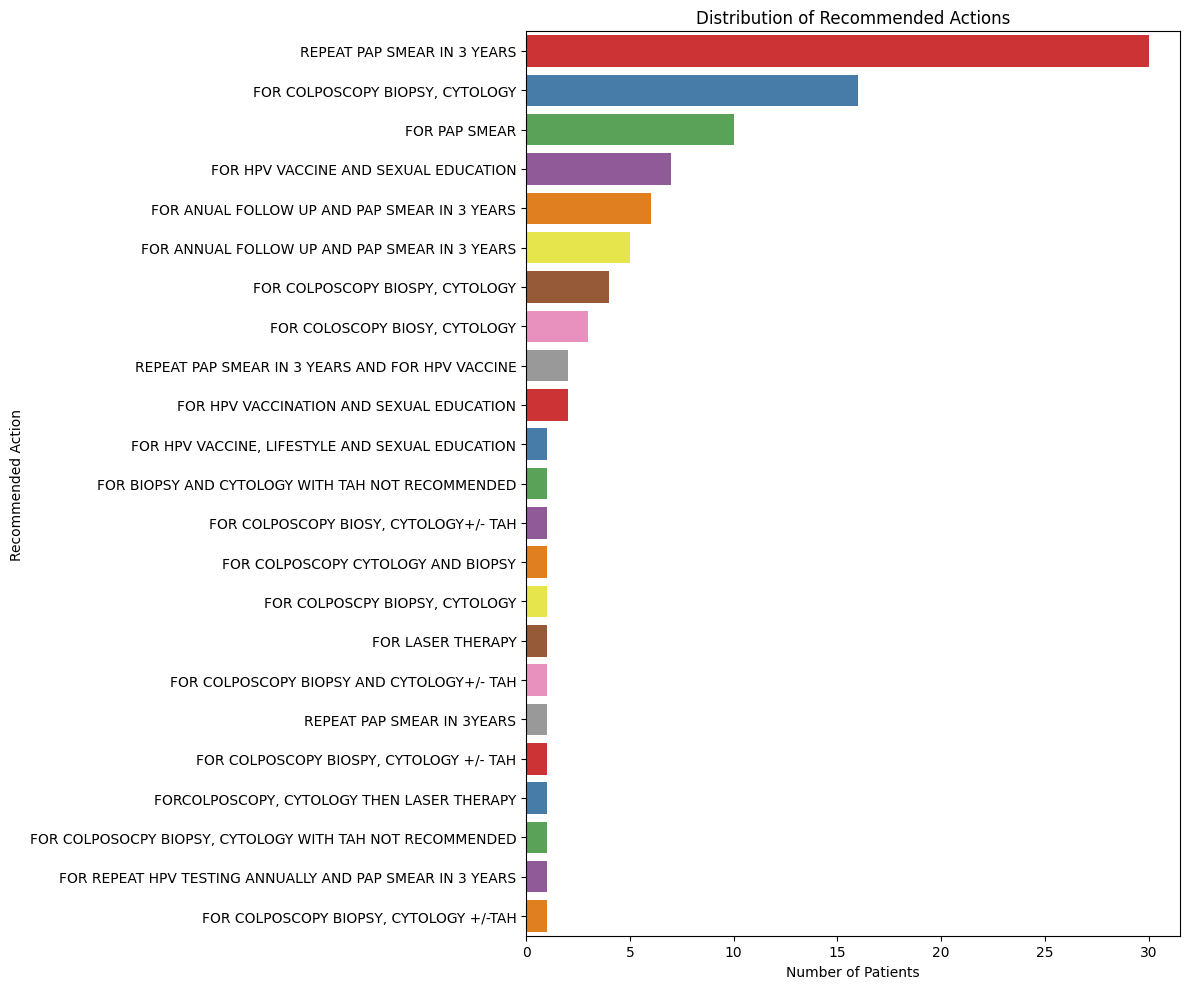

In [24]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# Distribution of Recommended Actions (from original column name)
plt.figure(figsize=(12, 10))
sns.countplot(
    data=final_df,
    y='Recommended Action',
    order=final_df['Recommended Action'].value_counts().index,
    palette='Set1'
    # palette='tab20'
)
plt.title("Distribution of Recommended Actions")
plt.xlabel("Number of Patients")
plt.ylabel("Recommended Action")
plt.tight_layout()
plt.show()


In [ ]:
print(final_df.columns.tolist())


In [ ]:
print("\n Summary of Categorical Columns")
print(final_df[categorical_cols].describe())

# for col in categorical_cols:
#     print(f"\n--- {col} ---")
#     print(final_df[col].value_counts())

/tmp/ipykernel_87651/4085060938.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')


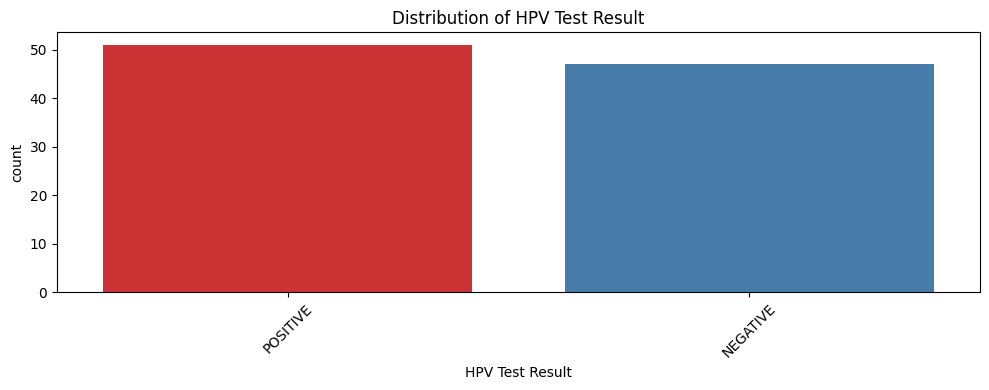

/tmp/ipykernel_87651/4085060938.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')


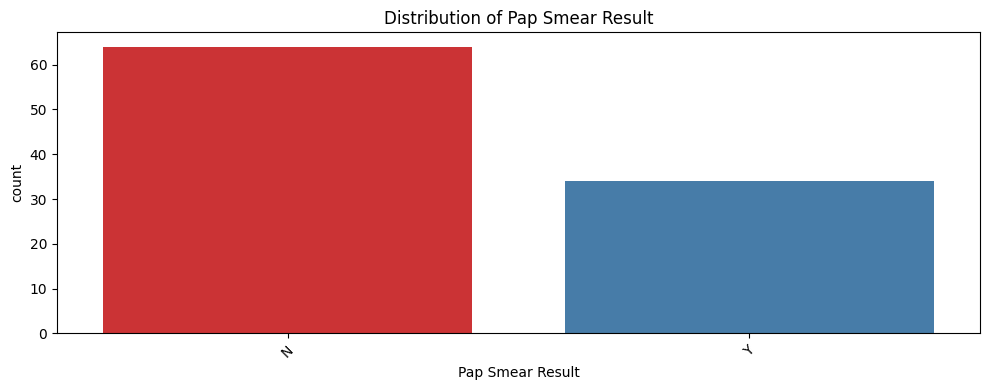

/tmp/ipykernel_87651/4085060938.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')


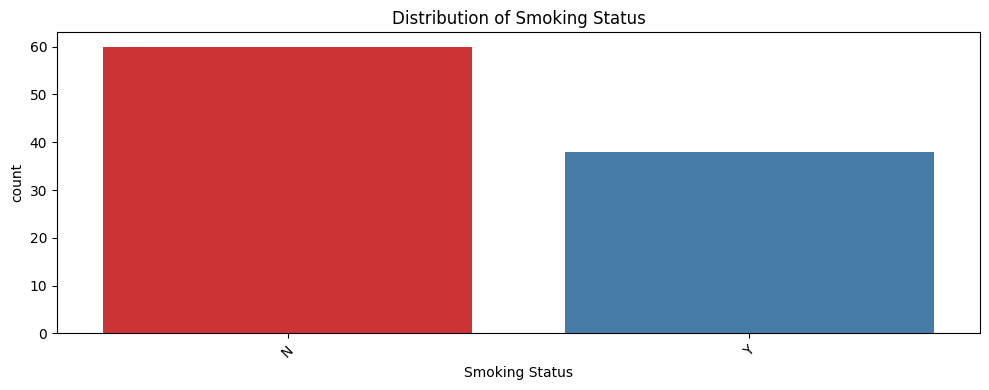

/tmp/ipykernel_87651/4085060938.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')


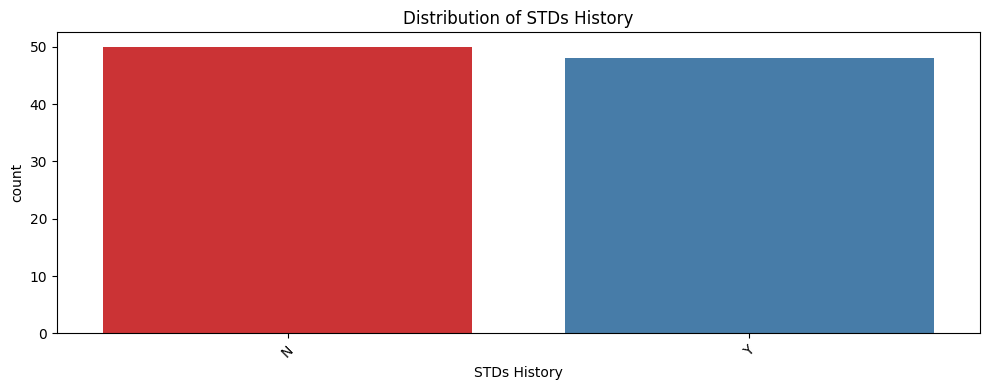

/tmp/ipykernel_87651/4085060938.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')


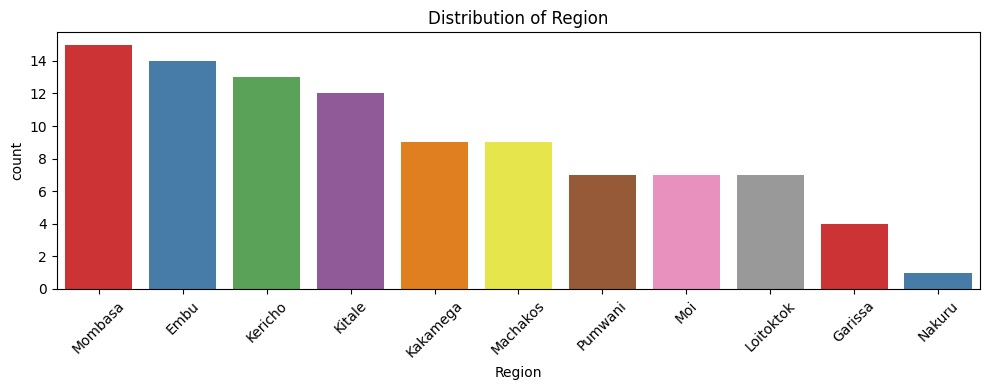

/tmp/ipykernel_87651/4085060938.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')


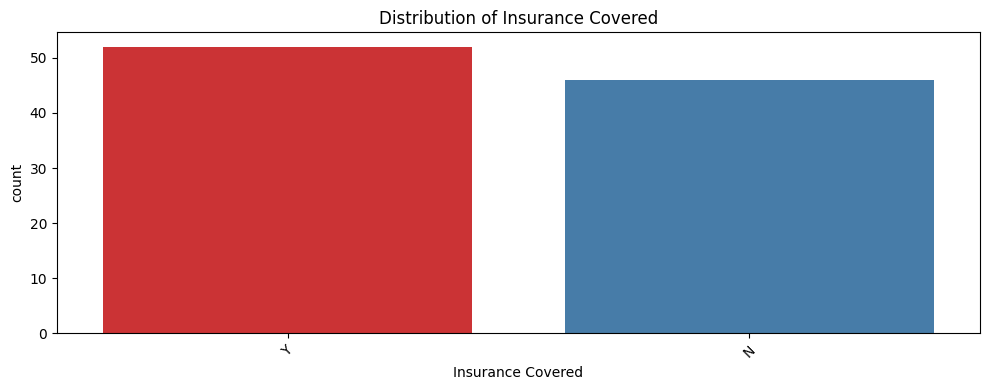

/tmp/ipykernel_87651/4085060938.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')


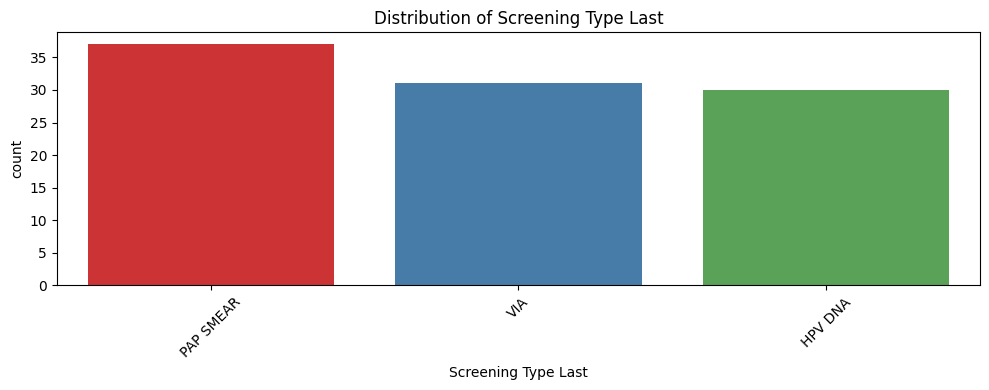

/tmp/ipykernel_87651/4085060938.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


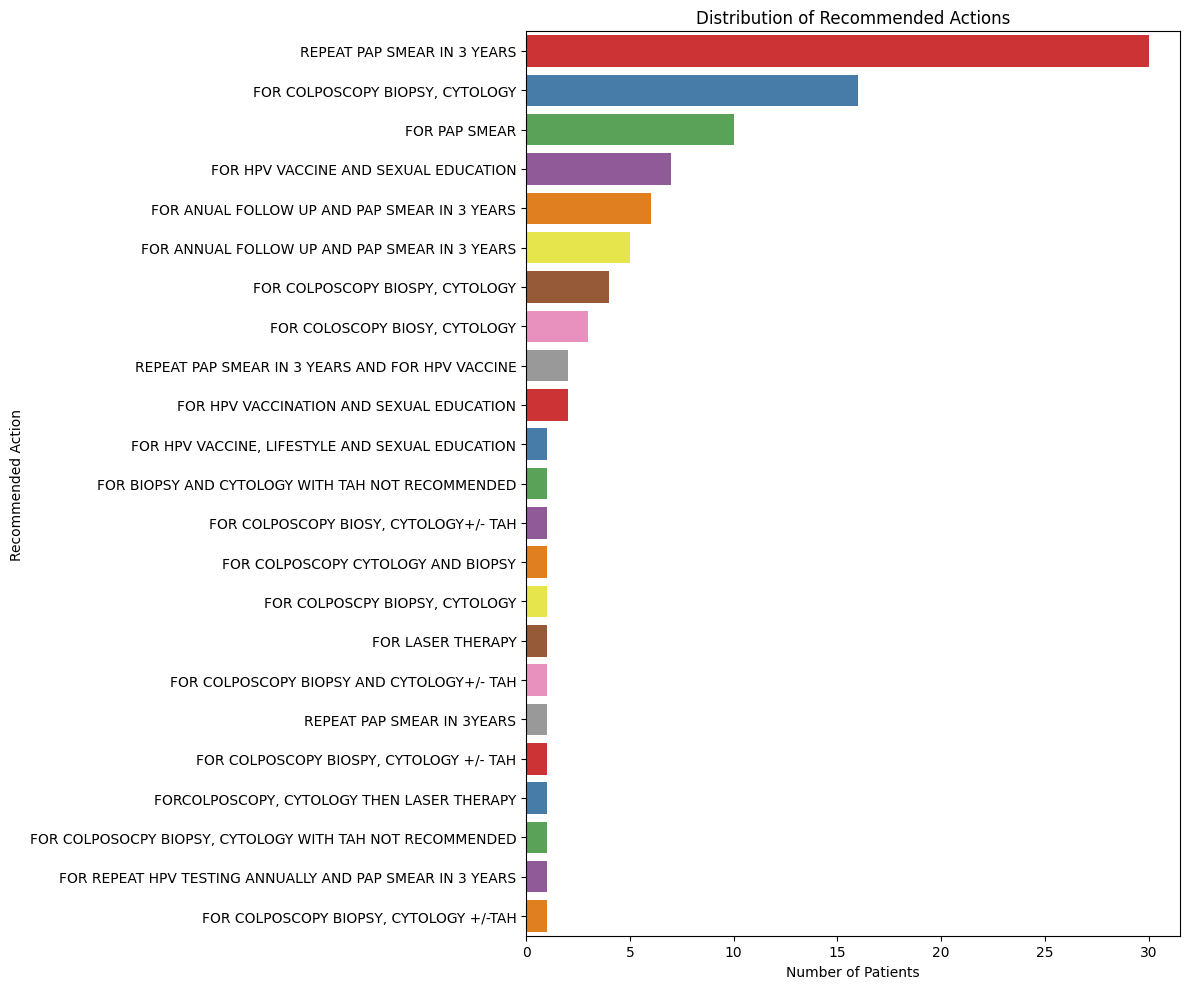

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot each categorical column EXCEPT Recommended Action
for col in categorical_cols:
    if col != 'Recommended Action':
        plt.figure(figsize=(10, 4))
        sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Handle 'Recommended Action' separately (horizontally)
plt.figure(figsize=(12, 10))
sns.countplot(
    data=final_df,
    y='Recommended Action',
    order=final_df['Recommended Action'].value_counts().index,
    palette='Set1'
)
plt.title("Distribution of Recommended Actions")
plt.xlabel("Number of Patients")
plt.ylabel("Recommended Action")
plt.tight_layout()
plt.show()



In [ ]:
#Histograms for Numerical Features
numerical_cols = ['Age', 'Sexual Partners', 'First Sexual Activity Age']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=final_df, x=col, kde=True, bins=30, color='dodgerblue')
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

In [ ]:
#Correlation Heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(final_df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Numerical Features')
plt.tight_layout()
plt.show()

In [ ]:
# 7. Summary Stats for Numeric Features
print("\n Summary of Numerical Columns ")
print(final_df[numerical_cols].describe())


# STEP 1: DATA SPLITTING
## Goal:  Split the dataset to get the portion that goes into training and the portion that goes into testing

We'll do:

* Pre-split Fix.We notice that in the dataset,some critical columns have only one instance of it.Here we will use simple oversampling by manually duplicating these classes with only one instance.
* Post-Split Oversampling- We will also perform SMOTE, only to the training set
* stratified splitting on the data to ensure equal amount of percentage goes into both training and testing.


In [27]:
# This list contains the final, correct values to use.
canonical_values = [
    "REPEAT PAP SMEAR IN 3 YEARS",
    "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY",
    "FOR PAP SMEAR",
    "FOR HPV VACCINE AND SEXUAL EDUCATION",
    "FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS",
    "REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE",
    "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)",
    "FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)",
    "FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION",
    "FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH",
    "FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY",
    "FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS",
    "FOR LASER THERAPY"
]

# --- 2. Configuration for the Cleaner ---
TYPO_MAP = {
    'COLPOSOCPY': 'COLPOSCOPY', 'COLPOSCPY': 'COLPOSCOPY', 'COLOSCOPY': 'COLPOSCOPY',
    'BIOSPY': 'BIOPSY', 'BIOSY': 'BIOPSY', 'ANUAL': 'ANNUAL', 'VACCINATION': 'VACCINE'
}
CRITICAL_KEYWORDS = {
    'COLPOSCOPY', 'BIOPSY', 'CYTOLOGY', 'TAH', 'HPV', 'LASER', 'LIFESTYLE', 'ANNUALLY'
}

# --- 3. The Definitive Data Cleaning Function ---
def clean_column_strict(df, column_to_clean, canonical_list, threshold=80):
    """
    Cleans a DataFrame column using fuzzy matching combined with a STRICT keyword set equality rule.
    """
    if column_to_clean not in df.columns:
        raise ValueError(f"Column '{column_to_clean}' not found in the DataFrame.")

    def preprocess_and_get_keywords(text, typo_map):
        if not isinstance(text, str): return "", set()
        # Standardize to uppercase and correct typos
        processed_text = text.upper()
        for wrong, right in typo_map.items():
            processed_text = re.sub(r'\b' + wrong + r'\b', right, processed_text)
        
        # Extract the set of critical keywords
        keywords = {word for word in CRITICAL_KEYWORDS if word in processed_text}
        return processed_text, keywords

    cleaned_data = []

    # Pre-calculate keywords for the canonical list for efficiency
    canonical_keywords = {val: preprocess_and_get_keywords(val, {})[1] for val in canonical_list}

    for index, row in df.iterrows():
        raw_string = row[column_to_clean]
        
        if not isinstance(raw_string, str) or not raw_string.strip():
            cleaned_data.append((raw_string, 0, 'NO_DATA_PROVIDED'))
            continue

        processed_string, original_keywords = preprocess_and_get_keywords(raw_string, TYPO_MAP)
        
        # Get the top few potential matches instead of just one
        top_matches = process.extract(processed_string, canonical_list, limit=5)

        best_valid_match = None
        
        for potential_match, score in top_matches:
            if score < threshold:
                break # No need to check further if scores are too low

            # The CRITICAL check: The keyword sets must be identical
            if original_keywords == canonical_keywords[potential_match]:
                best_valid_match = (potential_match, score)
                break # Found the best possible valid match, stop searching

        if best_valid_match:
            final_value, final_score = best_valid_match
            status = 'OK'
        else:
            final_value = raw_string
            final_score = top_matches[0][1] if top_matches else 0 # Show score of best (but invalid) match
            status = 'NEEDS MANUAL REVIEW'

        cleaned_data.append((final_value, final_score, status))

    result_df = pd.DataFrame(cleaned_data, index=df.index, columns=[f'{column_to_clean}_Cleaned', f'{column_to_clean}_Confidence', f'{column_to_clean}_Status'])
    return df.join(result_df)

# main_df = pd.DataFrame(data, columns=['Recommended Action'])


# 2. Call the function to clean the specified column
# You provide your DataFrame, the column name, the list of correct values, and the confidence threshold.
final_df = clean_column_strict(
    df=clean_df,
    column_to_clean='Recommended Action',
    canonical_list=canonical_values,
    threshold=80
)

# 3. Display the results
print("--- Full Data Cleaning Results ---")
# Use .to_string() to ensure all columns are displayed without truncation
#print(final_df.to_string())

print("\n" + "="*80 + "\n")

# 4. Display only the rows that need human attention
print("--- Actions Flagged for Manual Review (Confidence < 80%) ---")
manual_review_df = final_df[final_df['Recommended Action_Status'] == 'NEEDS MANUAL REVIEW']

if manual_review_df.empty:
    print("No actions require manual review. All items met the 80% confidence threshold.")
else:
    print(manual_review_df[['Recommended Action', 'Recommended Action_Cleaned', 'Recommended Action_Confidence']].to_string())


print(f"   After: {final_df['Recommended Action_Cleaned'].unique()}")
final_df
final_df.to_excel("final_cleaned.xlsx",index=False)



NameError: name 'clean_df' is not defined

In [ ]:
#Load the file
file_path = 'final_cleaned.xlsx'
df = pd.read_excel(file_path)
print("1. Removing unnecessary columns...")
columns_to_drop = ['Recommended Action','Recommended Action_Confidence','Recommended Action_Status','Patient ID']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
df.to_excel('data_final.xlsx', index=False)


# STEP 2: DATA SPLITTING
## Goal:  Split the dataset to get the portion that goes into training and the portion that goes into testing

We'll do:

* Pre-split Fix.We notice that in the dataset,some critical columns have only one instance of it.Here we will use simple oversampling by manually duplicating these classes with only one instance.
* stratified splitting on the data to ensure equal amount of percentage goes into both training and testing.
* hot-encode remaining columns
  # STEP 2B
  ## Goal :Define class weights based on domain knowledge(Medical) to be fed into the data for use during training .





In [ ]:
# --- 1. Load Your Data ---
# Let's create a sample DataFrame that mimics your situation

data = pd.read_excel('data_final.xlsx')
df = pd.DataFrame(data)

# --- 2. DEFINE TARGET and SEPARATE X and y ---
target_column = 'Recommended Action_Cleaned'
y = df[target_column]
X = df.drop(columns=[target_column])


# --- 3. PRE-SPLIT STEP: LABEL ENCODE THE TARGET COLUMN ---
# This is required so that the 'stratify' parameter can work with numeric labels.
print("\n--- 3. Label Encoding Target Column (y) ---")
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Target column converted to numeric labels.")
print("-" * 60)


# --- 4. PRE-SPLIT STEP: HANDLE SINGLE-INSTANCE CLASSES for STRATIFICATION ---
# Stratify needs at least 2 members per class. We duplicate the singletons.
print("\n--- 4. Checking for and Fixing Single-Instance Classes ---")
class_counts = pd.Series(y_encoded).value_counts()
single_instance_classes = class_counts[class_counts < 2].index

X_fixed = X.copy()
y_fixed = y_encoded.copy()

if len(single_instance_classes) > 0:
    print(f"Found {len(single_instance_classes)} classes with only one sample. Duplicating them...")
    
    indices_to_duplicate = pd.Series(y_encoded).isin(single_instance_classes)
    
    X_to_duplicate = X[indices_to_duplicate]
    y_to_duplicate = y_encoded[indices_to_duplicate]
    
    X_fixed = pd.concat([X, X_to_duplicate], ignore_index=True)
    y_fixed = pd.concat([pd.Series(y_encoded), pd.Series(y_to_duplicate)], ignore_index=True).values
else:
    print("No single-instance classes found that would break stratification.")

print(f"Shape before fix: {X.shape}. Shape after fix: {X_fixed.shape}.")
print("-" * 60)

    
# --- 5. SPLIT THE DATA (CRITICAL LEAKAGE-PREVENTION STEP) ---
# We split the 'fixed' data. X_fixed STILL CONTAINS THE TEXT/CATEGORICAL COLUMNS.
print("\n--- 5. Splitting Data into Training and Testing Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_fixed, y_fixed, 
    test_size=0.2,       # 20% for testing
    random_state=42,     # For reproducibility
    stratify=y_fixed     # Ensure class distribution is similar
)
print("Data successfully split.")
print(f"Training set size: {len(X_train)} rows")
print(f"Test set size: {len(X_test)} rows")
print("-" * 60)


# --- 6. ONE-HOT ENCODE THE FEATURE COLUMNS (POST-SPLIT) ---
# We learn the encoding schema ONLY from the training data to prevent data leakage.
print("\n--- 6. One-Hot Encoding Categorical Features ---")
# Automatically identify which columns are numeric and which are categorical from the training set
numeric_features = X_train.select_dtypes(include='number').columns
categorical_features = X_train.select_dtypes(include='object').columns

print(f"Identified Numeric Features: {list(numeric_features)}")
print(f"Identified Categorical Features: {list(categorical_features)}")

# Create the encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# FIT the encoder ONLY on the TRAINING data's categorical columns
encoder.fit(X_train[categorical_features])

# TRANSFORM both the training and testing data's categorical columns
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_train.index
)
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_test.index
)

# Reset index on all parts to ensure clean concatenation
X_train_numeric_reset = X_train[numeric_features].reset_index(drop=True)
X_test_numeric_reset = X_test[numeric_features].reset_index(drop=True)
X_train_encoded_reset = X_train_encoded.reset_index(drop=True)
X_test_encoded_reset = X_test_encoded.reset_index(drop=True)

# Combine encoded categorical columns with the original numeric columns
X_train_processed = pd.concat([X_train_numeric_reset, X_train_encoded_reset], axis=1)
X_test_processed = pd.concat([X_test_numeric_reset, X_test_encoded_reset], axis=1)

print("\nFeatures have been successfully encoded.")
print(f"Shape of processed training features: {X_train_processed.shape}")
print(f"Shape of processed testing features: {X_test_processed.shape}")
print("-" * 60)



# STEP 2: DATA SPLITTING
  ## Goal :Define class weights based on domain knowledge(Medical) to be fed into the data for use during training.

In [ ]:
print("\n--- 5. Manually Defining Class Weights Based on Clinical Importance ---")

# First, let's create a mapping from class names to their encoded labels for clarity
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class Label Mapping:")
print(label_mapping)

# ===================================================================================
# THIS IS WHERE YOU APPLY YOUR DOMAIN KNOWLEDGE.
# You create the dictionary from scratch. Higher weight = higher penalty for getting it wrong.
# You MUST provide a weight for every class label present in y_train.
# ===================================================================================
manual_weights_dict = {
    label_mapping['REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE']: 1.0, # Majority/common class
    label_mapping['FOR HPV VACCINE AND SEXUAL EDUCATION']: 1.2, # Slightly less common
    label_mapping['FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY']: 20.0, # IMPORTANT - High penalty
    label_mapping['FOR LASER THERAPY']: 30.0, # CRITICALLY IMPORTANT - Very high penalty
    label_mapping['FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH']: 25.0, # IMPORTANT - High penalty
    label_mapping["REPEAT PAP SMEAR IN 3 YEARS"]:10.0,
    label_mapping["FOR PAP SMEAR"]:5.0,
    label_mapping["FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS"]:20.0,
    label_mapping["FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION"]:1.5,
    label_mapping["FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY"] :30.0,
    label_mapping["FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS"]:25.0,
    label_mapping['FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)']: 20.0,
    label_mapping['FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)']: 20.0
}

print("\nCustom Weights Defined:")
print(manual_weights_dict)
print("-" * 60)



# STEP 3: Random Forest Classifier
## Goal: Understand the features which have more influence on the target column. The columns with the most correlation will then be used to train the model.


In [ ]:



# --- Stage A: Calculate Feature Importance and Select Features (on training data) ---
print("\n--- A. Calculating Feature Importance on Training Data ONLY ---")

# We train a preliminary RandomForest model to get feature importances.
# It's good practice to use the class weights here too so the importance calculation
# is not biased towards features that are only useful for the majority class.
feature_selector_model = RandomForestClassifier(
    random_state=42,
    class_weight=manual_weights_dict
)
feature_selector_model.fit(X_train_processed, y_train)

# Get the importance scores
importances = feature_selector_model.feature_importances_
feature_names = X_train_processed.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

print("Top 14 most important features (learned from training data):")
print(importance_df.head(14))

# --- Stage B: Perform the Feature Selection ---
print("\n--- B. Selecting Features Based on Importance ---")

# We can use a threshold (e.g., select features with importance > 0.01)
# Or we can use a helper like SelectFromModel to automatically select them.
# 'threshold="median"' will select all features with importance greater than the median.
selector = SelectFromModel(feature_selector_model, threshold='median', prefit=True)

# Use the selector to get the final versions of our datasets
X_train_final = selector.transform(X_train_processed)
X_test_final = selector.transform(X_test_processed) # Apply same transformation to test set

print(f"\nOriginal number of features: {X_train_processed.shape[1]}")
print(f"Number of features selected: {X_train_final.shape[1]}")
print("-" * 60)
